# Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning. (Portafolio Implementación)

Por: José Ángel Del Ángel Domínguez - A01749386

We will be using the 'Images of LEGO Bricks' dataset developed by JOOST HAZELZET on 2019, available on: https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images

The problem to solve is classifying the type of a given LEGO brick. The selected dataset consists of photos from 16 different lego bricks rendered using different angles on blender.

We hope that after generating a good model we can classify any given LEGO brick on real life. To achieve this we have to consider that all bricks on the dataset have the same brick color and background color, therefore we will perform data augmentation techniques to vary the given images.   

## 1 - Environment Configuration

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from matplotlib import image
import os
import random
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [5]:
from tensorflow.keras.layers import Layer
#from tensorflow import convert_to_tensor
import tensorflow as tf

In [6]:
data_dir_raw = "/content/drive/MyDrive/7mo semestre/IA_2/LEGO brick images v1 raw/"
data_dir_with_data_aug = "/content/drive/MyDrive/7mo semestre/IA_2/LEGO brick images v1/"
data_dir_final = "/content/drive/MyDrive/7mo semestre/IA_2/LEGO data final/"
models_path = "/content/drive/MyDrive/7mo semestre/IA_2/Models/"
classes = os.listdir(data_dir_raw)
classes_dirs_raw = [os.path.join(data_dir_raw, x) for x in classes]
classes_dirs_with_data_aug = [os.path.join(data_dir_with_data_aug, x) for x in classes]

## 2 - Exploratory data analysis

On this section we will be checking:
  - The number of photos from each class
  - The nature of the images on the dataset:
    - shape of the images
    - Color of the images
    - Ilumination and colors on each image  

Number of photos of each class:

In [ ]:
num_photos = {}
for i in range(len(classes)):
  class_name = classes[i]
  class_data_size = len(os.listdir(classes_dirs_raw[i]))
  num_photos[class_name] = [class_data_size]  
  print("{c}:".format(c = class_name))
  print("\t{num}".format(num = class_data_size))
num_photos_df = pd.DataFrame.from_dict(num_photos)

3003 Brick 2x2:
	400
2357 Brick corner 1x2x2:
	379
3004 Brick 1x2:
	400
3005 Brick 1x1:
	400
3024 Plate 1x1:
	400
18651 Cross Axle 2M with Snap friction:
	400
3023 Plate 1x2:
	400
11214 Bush 3M friction with Cross axle:
	400
3022 Plate 2x2:
	400
3040 Roof Tile 1x2x45deg:
	400
3713 Bush for Cross Axle:
	400
3794 Plate 1X2 with 1 Knob:
	400
3673 Peg 2M:
	400
32123 half Bush:
	400
3069 Flat Tile 1x2:
	400
6632 Technic Lever 3M:
	400


Shape of each image:

In [ ]:
sample_image1 = cv.imread(os.path.join(classes_dirs_raw[0], os.listdir(classes_dirs_raw[0])[0]))
sample_image2 = cv.imread(os.path.join(classes_dirs_raw[3], os.listdir(classes_dirs_raw[3])[0]))
print("sample image 1 shape: " + str(sample_image1.shape))
print("sample image 2 shape: " + str(sample_image2.shape))

sample image 1 shape: (200, 200, 3)
sample image 2 shape: (200, 200, 3)


The color and ilumination of each image on the dataset

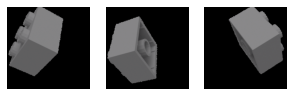

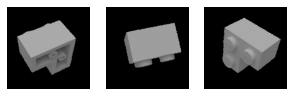

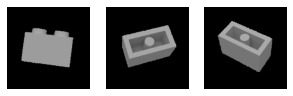

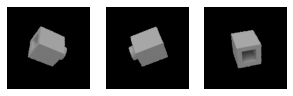

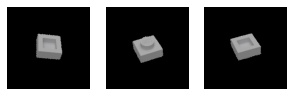

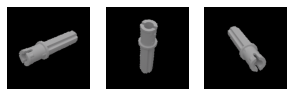

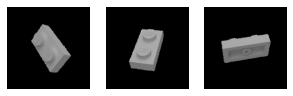

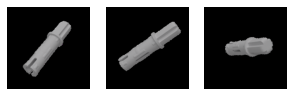

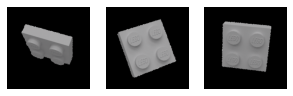

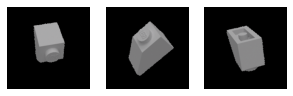

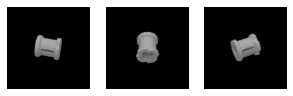

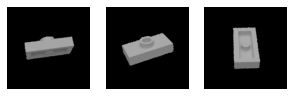

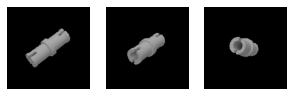

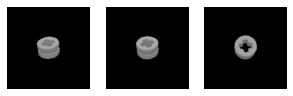

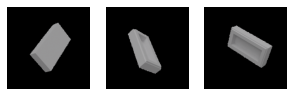

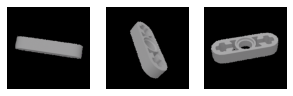

In [ ]:
num_classes = len(classes_dirs_raw)
test_photos = {}

for i in range(num_classes):
  current_class_dir = classes_dirs_raw[i]
  class_photos_names = os.listdir(current_class_dir)
  if i not in test_photos:
    test_photos[i] = []
  image1 = os.path.join( current_class_dir, random.choice(class_photos_names) )
  image2 = os.path.join( current_class_dir, random.choice(class_photos_names) )
  image3 = os.path.join( current_class_dir, random.choice(class_photos_names) )
  test_photos[i].append(cv.imread(image1))
  test_photos[i].append(cv.imread(image2))
  test_photos[i].append(cv.imread(image3))
  plt.rcParams["figure.figsize"] = (5,4)
  plt.subplot(1, 3, 1)
  plt.imshow(cv.cvtColor(cv.imread(image1),cv.COLOR_BGR2RGB))
  plt.axis("off")
  plt.subplot(1, 3, 2)
  plt.imshow(cv.cvtColor(cv.imread(image2),cv.COLOR_BGR2RGB))
  plt.axis("off")
  plt.subplot(1, 3, 3)
  plt.imshow(cv.cvtColor(cv.imread(image3),cv.COLOR_BGR2RGB))  
  plt.axis("off")
  plt.show()


## 3 - Data augmentation

From what we have seen on the images randomly selected from each class the images show how each LEGO brick looks like at many given angles and show small displacements of each one of the LEGO bricks.

However this images do not appear to represent:
  - The LEGO bricks with different colors and backgrounds
  - The LEGO bricks at different scales 
  - The LEGO bricks with some noise on the environment

Therefore we will proceed generating new images as follows:
  - We will double the dataset by inventing the colors of the current images  

**3.1 - Inverting the colors of each image**

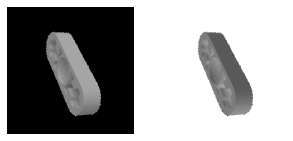

In [ ]:
num_classes = len(classes_dirs_raw)
original_photos = {}
inverted_photos = {}

for i in range(num_classes):
  current_class_dir = classes_dirs_raw[i]
  class_photos_names = os.listdir(current_class_dir)
  class_photos_dirs = [os.path.join(current_class_dir,x) for x in class_photos_names]
  if classes[i] not in original_photos:
    original_photos[classes[i]] = []
    inverted_photos[classes[i]] = []
  for photo_name in class_photos_dirs:
    original_photos[classes[i]].append(cv.imread(photo_name))
    inverted_photos[classes[i]].append(cv.bitwise_not(cv.imread(photo_name)))

plt.rcParams["figure.figsize"] = (5,4)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(original_photos[classes[i]][-1],cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(inverted_photos[classes[i]][-1],cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()



After veryfing that image inversion worked we will save the new inverted images into disk so that we can reset the 'inverted_photos' dir and  avoid wasting RAM memory

In [ ]:
for dict_key in inverted_photos:
  for j in range(len(inverted_photos[dict_key])):
    new_image_name = os.path.join(data_dir_with_data_aug, dict_key, "data_aug_inverted_{num}.png".format(num=j))
    cv.imwrite(new_image_name, inverted_photos[dict_key][j])

**3.2 - Changing the color of the lego bricks**

Next we will increase the new dataset by 50% by selecting random images from each class and changing its color to a new random color 

In [ ]:
hue_values_dial = [0, 1, 2, 3, 4, 5]
hue_values_dial = list(map(lambda x:np.uint8((x*180)/5), hue_values_dial))
print(hue_values_dial)

[0, 36, 72, 108, 144, 180]


The technique we will be using to change the color of the bricks is tranlating the image format from BGR to HSV color model and changing the HUE value.

The HSV model is as follows:

![hsv_color_model.png](https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/HSV_color_solid_cylinder_saturation_gray.png/197px-HSV_color_solid_cylinder_saturation_gray.png)

Lets test if our technique works:

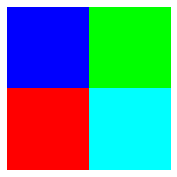

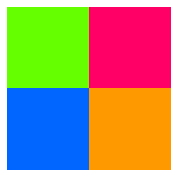

In [ ]:
image = [[[255,0,0],[0,255,0]],[[0,0,255],[255,255,0]]]
image = np.array(image, dtype = np.uint8)

hsv_photo = cv.cvtColor(image, cv.COLOR_BGR2HSV)
random_color = random.choice(hue_values_dial)
hsv_photo[:,:,0] = (hsv_photo[:,:,0]+random_color)%180 
hsv_photo = cv.cvtColor(hsv_photo, cv.COLOR_HSV2BGR)


plt.rcParams["figure.figsize"] = (4,3)
plt.imshow(cv.cvtColor(image,cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

plt.rcParams["figure.figsize"] = (4,3)
plt.imshow(cv.cvtColor(hsv_photo,cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

As we can see here the technique works. Lets test this technique with original photos and inverted photos.

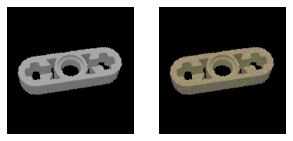

In [ ]:
colored_photos = {}

for class_name in original_photos:
  num_of_samples_to_color = int(len(original_photos[class_name])*(0.5))
  photos_to_color = random.sample(original_photos[class_name], num_of_samples_to_color)
  if class_name not in colored_photos:
    colored_photos[class_name] = []
  for photo in photos_to_color:
    hsv_photo = cv.cvtColor(photo, cv.COLOR_BGR2HSV)
    random_color = random.choice(hue_values_dial)
    hsv_photo[:,:,0] = (hsv_photo[:,:,0]+random_color)%180
    hsv_photo[:,:,1] = (hsv_photo[:,:,1]+80)%255
    hsv_photo = cv.cvtColor(hsv_photo, cv.COLOR_HSV2BGR)
    colored_photos[class_name].append(hsv_photo.copy())
plt.rcParams["figure.figsize"] = (5,4)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(photo,cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(hsv_photo,cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

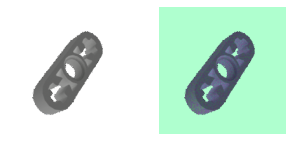

In [ ]:
for class_name in inverted_photos:
  num_of_samples_to_color = int(len(inverted_photos[class_name])*(0.5))
  photos_to_color = random.sample(inverted_photos[class_name], num_of_samples_to_color)
  if class_name not in colored_photos:
    colored_photos[class_name] = []
  for photo in photos_to_color:
    hsv_photo = cv.cvtColor(photo, cv.COLOR_BGR2HSV)
    random_color = random.choice(hue_values_dial)
    hsv_photo[:,:,0] = (hsv_photo[:,:,0]+random_color)%180
    hsv_photo[:,:,1] = (hsv_photo[:,:,1]+80)%255
    hsv_photo = cv.cvtColor(hsv_photo, cv.COLOR_HSV2BGR)
    colored_photos[class_name].append(hsv_photo.copy())
plt.rcParams["figure.figsize"] = (5,4)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(photo,cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(hsv_photo,cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

Now that we checked that our technique worked, we will save the colored images on the data augmentation dataset to avoid keeping them on the environment of this notebook and wasting RAM memory 

In [ ]:
for dict_key in colored_photos:
  for j in range(len(colored_photos[dict_key])):
    new_image_name = os.path.join(data_dir_with_data_aug, dict_key, "data_aug_colored_{num}.png".format(num=j))
    cv.imwrite(new_image_name, colored_photos[dict_key][j])

**3.3 - changing brick scale and brick positioning**

We will increase the current dataset by 33%. Downsizing each lego brick to 75% of the original brick size and positioning the reduced scale brick randomly on some of the following positions:
  - Center
  - Upper left corner
  - Upper right corner
  - Bottom left corner
  - Bottom right corner

As a starter lets define a function that will help us to position a smaller version of the image while keeping the same size of the image we will input to our DL model

In [ ]:
def fill_borders_to_get_resized_img(resized_image, new_position, desired_size= (200,200)):
  resized_image_dims = resized_image.shape[:2]
  if new_position == "center":
    vertical_border_size = int((desired_size[0] - resized_image_dims[0])/2)
    horizontal_border_size = int((desired_size[1] - resized_image_dims[1])/2)
    new_image = cv.copyMakeBorder(resized_image, vertical_border_size, vertical_border_size, horizontal_border_size, horizontal_border_size, cv.BORDER_REPLICATE)
  elif new_position == "upper_left_corner":
    vertical_border_size = int(desired_size[0] - resized_image_dims[0])
    horizontal_border_size = int(desired_size[1] - resized_image_dims[1])
    new_image = cv.copyMakeBorder(resized_image, 0, vertical_border_size, 0, horizontal_border_size, cv.BORDER_REPLICATE)
  elif new_position == "upper_right_corner":
    vertical_border_size = int(desired_size[0] - resized_image_dims[0])
    horizontal_border_size = int(desired_size[1] - resized_image_dims[1])
    new_image = cv.copyMakeBorder(resized_image, 0, vertical_border_size, horizontal_border_size, 0, cv.BORDER_REPLICATE)
  elif new_position == "bottom_left_corner":
    vertical_border_size = int(desired_size[0] - resized_image_dims[0])
    horizontal_border_size = int(desired_size[1] - resized_image_dims[1])
    new_image = cv.copyMakeBorder(resized_image, vertical_border_size, 0, 0, horizontal_border_size, cv.BORDER_REPLICATE)
  elif new_position == "bottom_right_corner":
    vertical_border_size = int(desired_size[0] - resized_image_dims[0])
    horizontal_border_size = int(desired_size[1] - resized_image_dims[1])
    new_image = cv.copyMakeBorder(resized_image, vertical_border_size, 0, horizontal_border_size, 0, cv.BORDER_REPLICATE)

  if new_image.shape[:2] != desired_size:
    new_image = cv.resize(new_image, desired_size, cv.INTER_LINEAR)
  return new_image

Now lets check if our method works by resizing the first image of the original dataset and repositiongning it at the center, upper left corner, upper right corner, bottom left corner and bottom right corner 

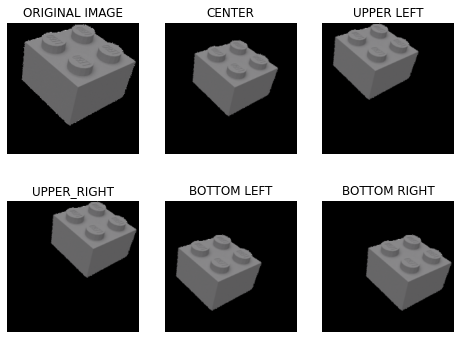

IMAGE SHAPES:
[(200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3), (200, 200, 3)]


In [ ]:
current_class_dir = classes_dirs_raw[0]
class_photos_names = os.listdir(current_class_dir)
class_photos_dirs = [os.path.join(current_class_dir,x) for x in class_photos_names]
first_photo_name = class_photos_dirs[0]
    
current_image_copy = cv.imread(first_photo_name).copy()
new_size = tuple(map(lambda x: int(x*0.75), current_image_copy.shape[:2]))
resized_image = cv.resize(current_image_copy, new_size, cv.INTER_LINEAR)
resized_image_center = fill_borders_to_get_resized_img(resized_image, "center")
resized_image_ul = fill_borders_to_get_resized_img(resized_image, "upper_left_corner")
resized_image_ur = fill_borders_to_get_resized_img(resized_image, "upper_right_corner")
resized_image_bl = fill_borders_to_get_resized_img(resized_image, "bottom_left_corner")
resized_image_br = fill_borders_to_get_resized_img(resized_image, "bottom_right_corner")

plt.rcParams["figure.figsize"] = (8,6)
plt.subplot(2,3, 1)
plt.imshow(cv.cvtColor(current_image_copy,cv.COLOR_BGR2RGB))
plt.title("ORIGINAL IMAGE")
plt.axis("off")
plt.subplot(2, 3, 2)
plt.imshow(cv.cvtColor(resized_image_center ,cv.COLOR_BGR2RGB))
plt.title("CENTER")
plt.axis("off")
plt.subplot(2,3, 3)
plt.imshow(cv.cvtColor(resized_image_ul ,cv.COLOR_BGR2RGB))
plt.title("UPPER LEFT")
plt.axis("off")
plt.subplot(2,3, 4)
plt.imshow(cv.cvtColor(resized_image_ur ,cv.COLOR_BGR2RGB))
plt.title("UPPER_RIGHT")
plt.axis("off")
plt.subplot(2,3, 5)
plt.imshow(cv.cvtColor(resized_image_bl ,cv.COLOR_BGR2RGB))
plt.title("BOTTOM LEFT")
plt.axis("off")
plt.subplot(2,3, 6)
plt.imshow(cv.cvtColor(resized_image_br ,cv.COLOR_BGR2RGB))
plt.title("BOTTOM RIGHT")
plt.axis("off")
plt.show()
print("IMAGE SHAPES:")
print([current_image_copy.shape, resized_image_center.shape, resized_image_ul.shape, resized_image_ur.shape, resized_image_bl.shape, resized_image_br.shape])

Now that we have confirmed that our technique works, lets use such technique to increase by 25% the dataset that exists after inverting photos color and coloring the LEGO pieces

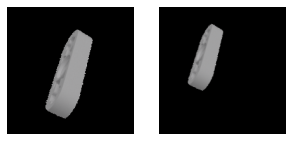

In [ ]:
num_classes = len(classes_dirs_with_data_aug)
current_photos = {}
resized_photos = {}
posible_positions = ["center", "upper_left_corner", "upper_right_corner", "bottom_left_corner", "bottom_right_corner"]

for i in range(num_classes):
  current_class_dir = classes_dirs_with_data_aug[i]
  class_photos_names = os.listdir(current_class_dir)
  class_photos_dirs = [os.path.join(current_class_dir,x) for x in class_photos_names]  
  num_of_samples_to_reposition = int(len(class_photos_dirs)*(0.33))
  class_photos_dirs = random.sample(class_photos_dirs, num_of_samples_to_reposition)
  if classes[i] not in current_photos:
    current_photos[classes[i]] = []
    resized_photos[classes[i]] = []
  for photo_name in class_photos_dirs:    
    current_image_copy = cv.imread(photo_name).copy()
    current_photos[classes[i]].append(current_image_copy)
    new_size = tuple(map(lambda x: int(x*0.75), current_image_copy.shape[:2]))
    resized_image = cv.resize(current_image_copy, new_size, cv.INTER_LINEAR)
    resized_image = fill_borders_to_get_resized_img(resized_image, random.choice(posible_positions))
    resized_photos[classes[i]].append(resized_image)
plt.rcParams["figure.figsize"] = (5,4)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(current_image_copy,cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(resized_image,cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:
for dict_key in resized_photos:
  for j in range(len(resized_photos[dict_key])):
    new_image_name = os.path.join(data_dir_with_data_aug, dict_key, "data_aug_resized_{num}.png".format(num=j))
    cv.imwrite(new_image_name, resized_photos[dict_key][j])

**3.4 - Checking the results of the data augmentation process**

Now that we have completed the data augmentation process we expect to have a dataset of approximately 1600 photos per class on the `data_dir_with_data_aug` directory

In [ ]:
for i in range(len(classes)):
  class_name = classes[i]
  class_data_size = len(os.listdir(classes_dirs_with_data_aug[i]))
  print("{c}:".format(c = class_name))
  print("\t{num}".format(num = class_data_size))

3003 Brick 2x2:
	1596
2357 Brick corner 1x2x2:
	1510
3004 Brick 1x2:
	1596
3005 Brick 1x1:
	1596
3024 Plate 1x1:
	1596
18651 Cross Axle 2M with Snap friction:
	1596
3023 Plate 1x2:
	1596
11214 Bush 3M friction with Cross axle:
	1596
3022 Plate 2x2:
	1596
3040 Roof Tile 1x2x45deg:
	1596
3713 Bush for Cross Axle:
	1596
3794 Plate 1X2 with 1 Knob:
	1596
3673 Peg 2M:
	1596
32123 half Bush:
	1596
3069 Flat Tile 1x2:
	1596
6632 Technic Lever 3M:
	1596


As we can see we do have the expected number of photos on our new dataset. 

Lets visualize the new photos of each class:

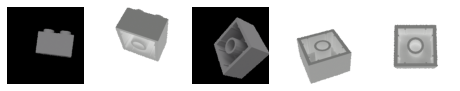

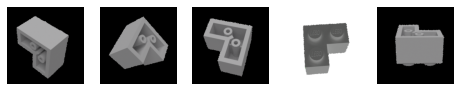

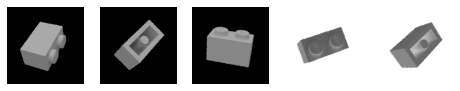

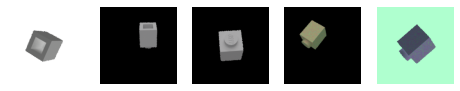

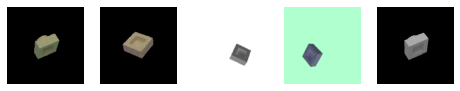

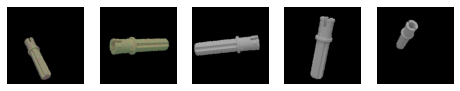

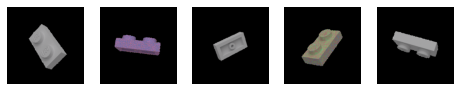

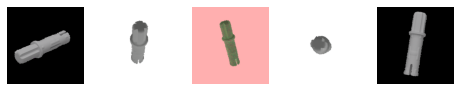

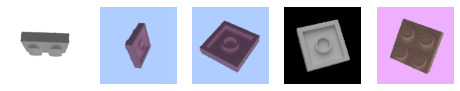

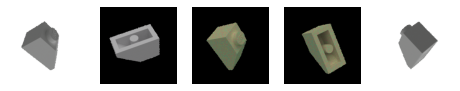

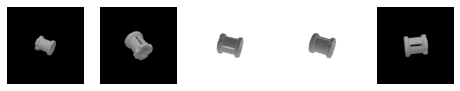

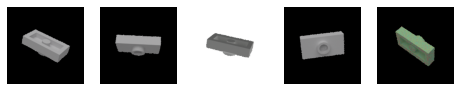

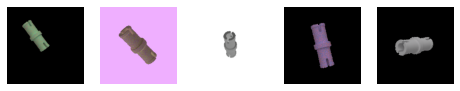

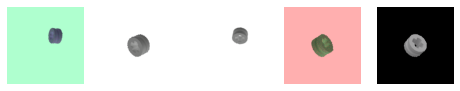

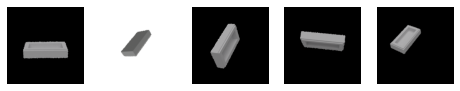

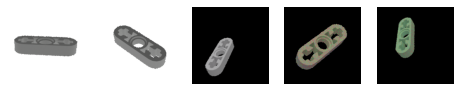

In [ ]:
num_classes = len(classes_dirs_with_data_aug)

for i in range(num_classes):
  current_class_dir = classes_dirs_with_data_aug[i]
  class_photos_names = os.listdir(current_class_dir)
  image1 = os.path.join( current_class_dir, random.choice(class_photos_names) )
  image2 = os.path.join( current_class_dir, random.choice(class_photos_names) )
  image3 = os.path.join( current_class_dir, random.choice(class_photos_names) )
  image4 = os.path.join( current_class_dir, random.choice(class_photos_names) )
  image5 = os.path.join( current_class_dir, random.choice(class_photos_names) )
  plt.rcParams["figure.figsize"] = (8,6)
  plt.subplot(1, 5, 1)
  plt.imshow(cv.cvtColor(cv.imread(image1),cv.COLOR_BGR2RGB))
  plt.axis("off")
  plt.subplot(1, 5, 2)
  plt.imshow(cv.cvtColor(cv.imread(image2),cv.COLOR_BGR2RGB))
  plt.axis("off")
  plt.subplot(1, 5, 3)
  plt.imshow(cv.cvtColor(cv.imread(image3),cv.COLOR_BGR2RGB))  
  plt.axis("off")
  plt.subplot(1, 5, 4)
  plt.imshow(cv.cvtColor(cv.imread(image4),cv.COLOR_BGR2RGB))
  plt.axis("off")
  plt.subplot(1, 5, 5)
  plt.imshow(cv.cvtColor(cv.imread(image5),cv.COLOR_BGR2RGB))
  plt.axis("off")
  plt.show()


As we can see data augmentation process worked, now we can free up some RAM by droping all existing values on the images dictionaries that we wont use any more

In [ ]:
original_photos = {}
inverted_photos = {}
colored_photos = {}
current_photos = {}
resized_photos = {}

## 4 - Preparing data for Deep Learning Models

As we saw on the Exploratory Data Analysis and the Data Augmentation Section the dataset that we will be using has a huge amount of rotations and we know that CNNs, which are the basis of modern deep learning techniques, are invariable to repositioning and rescaling but not invariable to rotation.

Therefore we will have to use a CNN that captures a lot of features to fight with the rotations on dataset.

Additionaly knowing that colors are not a feature that distingushes one LEGO brick from another, it is possible that spliting the image on the R, G and B channels will not work, thus we will try approaches different to a Depthwise Separable  Conv (DSC) network.

Also we know there is no need to memorize anything to achive the LEGO brick classification task, thus we will try approaches different to RNNs and LSTM.

Since we need a large number of features and many deep layers we will use approches that prevent the vanishing gradient problem. We will evaluate:

1 - A deep CNN with HE initialization, ReLU activation function and Batch normalization

2 - GoogleNet


**4.1 - Setting up the dataset so that we can load batch by batch into RAM**

In [ ]:
train_images_dirs = {}
validation_images_dirs = {}
test_images_dirs = {}

# we will be making a train test split of 80 vs 20 percent
for i in range(len(classes)):
  current_class_dir = classes_dirs_with_data_aug[i]
  class_photos_names = os.listdir(current_class_dir)
  class_photos_dirs = [os.path.join(current_class_dir,x) for x in class_photos_names]  
  num_of_train_samples = int(len(class_photos_dirs)*(0.80))
  train_samples = random.sample(class_photos_dirs, num_of_train_samples)
  test_samples = [sample for sample in class_photos_dirs if sample not in train_samples]
  num_of_validation_samples = int(len(train_samples)*(0.10))
  validation_samples = random.sample(train_samples, num_of_validation_samples)
  train_samples = [sample for sample in train_samples if sample not in validation_samples]
  
  train_images_dirs[classes[i]] = train_samples
  validation_images_dirs[classes[i]] = validation_samples
  test_images_dirs[classes[i]] = test_samples

  if len(train_samples) + len(validation_samples) + len(test_samples) != len(class_photos_dirs):
    print("invalid split on class: " + classes[i])
    break
  

In [ ]:
class_to_int_map = {}
int_to_class_map = {}
class_index = 0
for class_name in classes:
  class_to_int_map[class_name] = class_index
  int_to_class_map[class_index] = class_name
  class_index += 1

print(class_to_int_map)

{'3003 Brick 2x2': 0, '2357 Brick corner 1x2x2': 1, '3004 Brick 1x2': 2, '3005 Brick 1x1': 3, '3024 Plate 1x1': 4, '18651 Cross Axle 2M with Snap friction': 5, '3023 Plate 1x2': 6, '11214 Bush 3M friction with Cross axle': 7, '3022 Plate 2x2': 8, '3040 Roof Tile 1x2x45deg': 9, '3713 Bush for Cross Axle': 10, '3794 Plate 1X2 with 1 Knob': 11, '3673 Peg 2M': 12, '32123 half Bush': 13, '3069 Flat Tile 1x2': 14, '6632 Technic Lever 3M': 15}


In [ ]:
for class_name in classes:
  i_train = 0
  for image_name in train_images_dirs[class_name]:
    train_image_copy = cv.imread(image_name).copy()
    new_dir = os.path.join(data_dir_final, "train", str(class_to_int_map[class_name]) , "train_img_{i}.jpg".format(i=i_train))
    cv.imwrite(new_dir, train_image_copy)
    i_train += 1
  
  i_validation = 0
  for image_name in validation_images_dirs[class_name]:
    validation_image_copy = cv.imread(image_name).copy()
    new_dir = os.path.join(data_dir_final, "validation", str(class_to_int_map[class_name]) ,"validation_img_{i}.jpg".format(i=i_validation))
    cv.imwrite(new_dir, validation_image_copy)
    i_validation += 1

  i_test = 0
  for image_name in test_images_dirs[class_name]:
    test_image_copy = cv.imread(image_name).copy()
    new_dir = os.path.join(data_dir_final, "test", str(class_to_int_map[class_name]) ,"test_img_{i}.jpg".format(i=i_test))
    cv.imwrite(new_dir, test_image_copy)
    i_test += 1
  

## 5 - Creating the CNN model

In [ ]:
def get_cnn_model():
  model = Sequential()
  model.add(Input(shape= (200,200,3)))
  model.add(Rescaling(1.0/255.0))
  model.add(Conv2D(32, (5,5), activation = "relu", kernel_initializer="he_normal"))
  model.add(Dropout(0.4))
  model.add( MaxPooling2D() )
  model.add(Conv2D(64, (5,5), activation = "relu", kernel_initializer="he_normal"))
  model.add(Dropout(0.4))
  model.add( MaxPooling2D() )  
  model.add(Conv2D(128, (5,5), activation = "relu", kernel_initializer="he_normal")) # size output here should be 50*50
  model.add(Dropout(0.4))
  model.add( MaxPooling2D() )
  model.add(Conv2D(128, (3,3), activation = "relu", kernel_initializer="he_normal")) # size output here should be 25*25
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(128,activation = "relu", kernel_initializer="he_normal"))
  model.add(Dropout(0.4))
  model.add(Dense(128,activation = "relu", kernel_initializer="he_normal"))
  model.add(Dropout(0.4))
  model.add(Dense(64,activation = "relu", kernel_initializer="he_normal"))
  model.add(Dropout(0.4))
  model.add(Dense(32,activation = "relu", kernel_initializer="he_normal"))  
  model.add(Dropout(0.4))
  model.add(Dense(16,activation = "softmax", kernel_initializer="he_normal")) # otput corresponds to 16 classes
  
  return model

In [ ]:
model = get_cnn_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_246 (Conv2D)         (None, 196, 196, 32)      2432      
                                                                 
 dropout_34 (Dropout)        (None, 196, 196, 32)      0         
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 98, 98, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_247 (Conv2D)         (None, 94, 94, 64)        51264     
                                                                 
 dropout_35 (Dropout)        (None, 94, 94, 64)        0         
                                                      

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=[ 'accuracy', BinaryAccuracy(), AUC(), ]) 

**5.2 - Training the CNN model**

In [ ]:
print("for train data: ")
train_dataset = image_dataset_from_directory( os.path.join(data_dir_final, "train") , image_size=(200,200), batch_size=10, label_mode = "categorical" )
print("for validation data: ")
validation_dataset = image_dataset_from_directory( os.path.join(data_dir_final, "validation") , image_size=(200,200), batch_size=10, label_mode = "categorical" )
print("for test data: ")
test_dataset = image_dataset_from_directory( os.path.join(data_dir_final, "test") , image_size=(200,200), batch_size=10, label_mode = "categorical" )

for train data: 
Found 18323 files belonging to 16 classes.
for validation data: 
Found 2025 files belonging to 16 classes.
for test data: 
Found 5102 files belonging to 16 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  print(labels_batch)
  break

data batch shape: (10, 200, 200, 3)
labels batch shape: (10, 16)
tf.Tensor(
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 16), dtype=float32)


now lets add a checkpoint to save the weights of the model with best performance on validation loss

In [ ]:
callbacks = [
    ModelCheckpoint(
        filepath= os.path.join( models_path, "cnn_model" ),
        save_best_only=True,
        monitor="val_loss"),
    EarlyStopping(monitor='accuracy', patience=5)
]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=150,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/150
1831/1833 [============================>.] - ETA: 0s - loss: 2.8878 - accuracy: 0.0659 - binary_accuracy: 0.9372 - auc_6: 0.5104

1833/1833 [==============================] - 57s 30ms/step - loss: 2.8877 - accuracy: 0.0659 - binary_accuracy: 0.9372 - auc_6: 0.5104 - val_loss: 2.7673 - val_accuracy: 0.0840 - val_binary_accuracy: 0.9375 - val_auc_6: 0.5309
Epoch 2/150
1831/1833 [============================>.] - ETA: 0s - loss: 2.6186 - accuracy: 0.1114 - binary_accuracy: 0.9373 - auc_6: 0.6535

1833/1833 [==============================] - 56s 30ms/step - loss: 2.6184 - accuracy: 0.1114 - binary_accuracy: 0.9373 - auc_6: 0.6536 - val_loss: 2.5005 - val_accuracy: 0.2059 - val_binary_accuracy: 0.9375 - val_auc_6: 0.7859
Epoch 3/150
1831/1833 [============================>.] - ETA: 0s - loss: 2.0762 - accuracy: 0.2612 - binary_accuracy: 0.9396 - auc_6: 0.8353

1833/1833 [==============================] - 56s 30ms/step - loss: 2.0764 - accuracy: 0.2611 - binary_accuracy: 0.9396 - auc_6: 0.8352 - val_loss: 2.0674 - val_accuracy: 0.2899 - val_binary_accuracy: 0.9382 - val_auc_6: 0.8542
Epoch 4/150
1832/1833 [============================>.] - ETA: 0s - loss: 1.7269 - accuracy: 0.3637 - binary_accuracy: 0.9416 - auc_6: 0.8943

1833/1833 [==============================] - 56s 30ms/step - loss: 1.7268 - accuracy: 0.3638 - binary_accuracy: 0.9416 - auc_6: 0.8943 - val_loss: 1.6250 - val_accuracy: 0.4272 - val_binary_accuracy: 0.9428 - val_auc_6: 0.9218
Epoch 5/150
1833/1833 [==============================] - 53s 29ms/step - loss: 1.4963 - accuracy: 0.4339 - binary_accuracy: 0.9452 - auc_6: 0.9219 - val_loss: 1.6610 - val_accuracy: 0.4089 - val_binary_accuracy: 0.9438 - val_auc_6: 0.9108
Epoch 6/150
1831/1833 [============================>.] - ETA: 0s - loss: 1.3500 - accuracy: 0.4906 - binary_accuracy: 0.9488 - auc_6: 0.9366

1833/1833 [==============================] - 56s 30ms/step - loss: 1.3498 - accuracy: 0.4906 - binary_accuracy: 0.9488 - auc_6: 0.9366 - val_loss: 1.3848 - val_accuracy: 0.5042 - val_binary_accuracy: 0.9468 - val_auc_6: 0.9446
Epoch 7/150
1833/1833 [==============================] - 53s 29ms/step - loss: 1.2685 - accuracy: 0.5276 - binary_accuracy: 0.9515 - auc_6: 0.9441 - val_loss: 1.5044 - val_accuracy: 0.4686 - val_binary_accuracy: 0.9461 - val_auc_6: 0.9271
Epoch 8/150
1833/1833 [==============================] - 53s 29ms/step - loss: 1.1871 - accuracy: 0.5558 - binary_accuracy: 0.9535 - auc_6: 0.9508 - val_loss: 1.5753 - val_accuracy: 0.4400 - val_binary_accuracy: 0.9444 - val_auc_6: 0.9185
Epoch 9/150
1831/1833 [============================>.] - ETA: 0s - loss: 1.1179 - accuracy: 0.5797 - binary_accuracy: 0.9560 - auc_6: 0.9559

1833/1833 [==============================] - 55s 30ms/step - loss: 1.1183 - accuracy: 0.5797 - binary_accuracy: 0.9560 - auc_6: 0.9559 - val_loss: 1.2359 - val_accuracy: 0.5837 - val_binary_accuracy: 0.9525 - val_auc_6: 0.9552
Epoch 10/150
1831/1833 [============================>.] - ETA: 0s - loss: 1.1183 - accuracy: 0.5832 - binary_accuracy: 0.9567 - auc_6: 0.9558

1833/1833 [==============================] - 56s 31ms/step - loss: 1.1182 - accuracy: 0.5833 - binary_accuracy: 0.9567 - auc_6: 0.9558 - val_loss: 1.1431 - val_accuracy: 0.6005 - val_binary_accuracy: 0.9544 - val_auc_6: 0.9642
Epoch 11/150
1833/1833 [==============================] - 54s 29ms/step - loss: 1.0487 - accuracy: 0.6116 - binary_accuracy: 0.9584 - auc_6: 0.9614 - val_loss: 1.4300 - val_accuracy: 0.4711 - val_binary_accuracy: 0.9481 - val_auc_6: 0.9365
Epoch 12/150
1833/1833 [==============================] - 54s 29ms/step - loss: 1.0679 - accuracy: 0.6099 - binary_accuracy: 0.9584 - auc_6: 0.9596 - val_loss: 1.3861 - val_accuracy: 0.4790 - val_binary_accuracy: 0.9484 - val_auc_6: 0.9418
Epoch 13/150
1833/1833 [==============================] - 54s 29ms/step - loss: 0.9909 - accuracy: 0.6290 - binary_accuracy: 0.9596 - auc_6: 0.9656 - val_loss: 1.5879 - val_accuracy: 0.4114 - val_binary_accuracy: 0.9466 - val_auc_6: 0.9096
Epoch 14/150
1833/1833 [=============================

1833/1833 [==============================] - 56s 30ms/step - loss: 0.8961 - accuracy: 0.6808 - binary_accuracy: 0.9638 - auc_6: 0.9707 - val_loss: 1.0423 - val_accuracy: 0.6262 - val_binary_accuracy: 0.9598 - val_auc_6: 0.9667
Epoch 20/150
1833/1833 [==============================] - 53s 29ms/step - loss: 0.8732 - accuracy: 0.6814 - binary_accuracy: 0.9646 - auc_6: 0.9720 - val_loss: 1.3860 - val_accuracy: 0.5027 - val_binary_accuracy: 0.9517 - val_auc_6: 0.9335
Epoch 21/150
1833/1833 [==============================] - 54s 29ms/step - loss: 0.9309 - accuracy: 0.6707 - binary_accuracy: 0.9638 - auc_6: 0.9684 - val_loss: 1.2685 - val_accuracy: 0.5077 - val_binary_accuracy: 0.9525 - val_auc_6: 0.9479
Epoch 22/150
1833/1833 [==============================] - 53s 29ms/step - loss: 0.8795 - accuracy: 0.6849 - binary_accuracy: 0.9649 - auc_6: 0.9720 - val_loss: 1.5437 - val_accuracy: 0.4183 - val_binary_accuracy: 0.9460 - val_auc_6: 0.9177
Epoch 23/150
1833/1833 [=============================

1833/1833 [==============================] - 56s 30ms/step - loss: 0.8315 - accuracy: 0.7172 - binary_accuracy: 0.9681 - auc_6: 0.9740 - val_loss: 0.9460 - val_accuracy: 0.7116 - val_binary_accuracy: 0.9643 - val_auc_6: 0.9744
Epoch 41/150
1833/1833 [==============================] - 53s 29ms/step - loss: 0.7902 - accuracy: 0.7294 - binary_accuracy: 0.9691 - auc_6: 0.9767 - val_loss: 1.9012 - val_accuracy: 0.5175 - val_binary_accuracy: 0.9486 - val_auc_6: 0.8947
Epoch 42/150
1833/1833 [==============================] - 53s 29ms/step - loss: 0.7938 - accuracy: 0.7290 - binary_accuracy: 0.9692 - auc_6: 0.9760 - val_loss: 1.6862 - val_accuracy: 0.5185 - val_binary_accuracy: 0.9497 - val_auc_6: 0.9071
Epoch 43/150
1833/1833 [==============================] - 53s 29ms/step - loss: 0.7686 - accuracy: 0.7378 - binary_accuracy: 0.9701 - auc_6: 0.9775 - val_loss: 0.9544 - val_accuracy: 0.6849 - val_binary_accuracy: 0.9629 - val_auc_6: 0.9720
Epoch 44/150
1833/1833 [=============================

**5.3 - plotting the results of the cnn model**

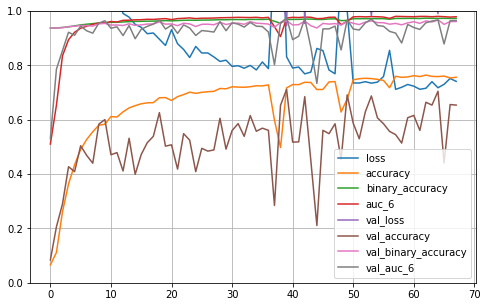

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

**5.4 - Evaluating the model using the test data**

In [ ]:
cnn_model = load_model( os.path.join( models_path, "cnn_model" ) )
cnn_model.evaluate(test_dataset)

511/511 [==============================] - 500s 958ms/step - loss: 0.9591 - accuracy: 0.6929 - binary_accuracy: 0.9635 - auc_6: 0.9734


[0.9591160416603088,
 0.6928655505180359,
 0.9634824395179749,
 0.9733745455741882]

**5.5 Making some predictions with the saved model**

In [ ]:
class_to_int_map = {}
int_to_class_map = {}
class_index = 0
for class_name in classes:
  class_to_int_map[class_name] = class_index
  int_to_class_map[class_index] = class_name
  class_index += 1

print(class_to_int_map)

{'3003 Brick 2x2': 0, '2357 Brick corner 1x2x2': 1, '3004 Brick 1x2': 2, '3005 Brick 1x1': 3, '3024 Plate 1x1': 4, '18651 Cross Axle 2M with Snap friction': 5, '3023 Plate 1x2': 6, '11214 Bush 3M friction with Cross axle': 7, '3022 Plate 2x2': 8, '3040 Roof Tile 1x2x45deg': 9, '3713 Bush for Cross Axle': 10, '3794 Plate 1X2 with 1 Knob': 11, '3673 Peg 2M': 12, '32123 half Bush': 13, '3069 Flat Tile 1x2': 14, '6632 Technic Lever 3M': 15}


1/1 [==============================] - 0s 18ms/step
[1.0, 2.2938756e-10, 0.0, 0.0, 0.0, 0.0, 0.0, 6.379521e-21, 4.8412052e-30, 0.0, 0.0, 2.6244509e-20, 0.0, 2.3705482e-22, 7.635974e-09, 5.0451084e-31]
real label: 3003 Brick 2x2
predicted label 3003 Brick 2x2


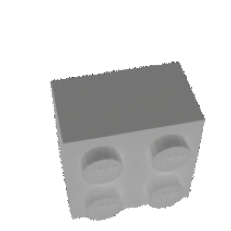

In [ ]:
random_class = random.randrange(16)
random_sample = random.randrange(100)

prediction_sample = cv.imread( os.path.join( classes_dirs_with_data_aug[random_class], os.listdir(classes_dirs_with_data_aug[random_class])[random_sample] ) )
plt.rcParams["figure.figsize"] = (5,4)
plt.subplot(1, 1, 1)
plt.imshow(cv.cvtColor(prediction_sample,cv.COLOR_BGR2RGB))
plt.axis("off")

prediction_sample = np.expand_dims(prediction_sample, axis = 0)
model_prediction_vector = list(model.predict(prediction_sample)[0])
model_prediction = int_to_class_map[model_prediction_vector.index(max(model_prediction_vector))]

print(model_prediction_vector)
print("real label: {r}".format(r = int_to_class_map[random_class]))
print("predicted label {p}".format( p = model_prediction )) 

## 6 - Testing GoogleNet on our dataset

In [ ]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [ ]:
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (200, 200, 3))

  # input rescaling
  X = Rescaling(1.0/255.0)(input_layer)

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(X) # 100x100 image size

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)    #50x50 image size

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)
  
  # 4th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)
  X = Dropout(0.4)(X)
  X = Dense(512,activation = "relu")(X)
  X = Dropout(0.4)(X)
  X = Dense(256,activation = "relu")(X)
  X = Dropout(0.4)(X)
  X = Dense(128,activation = "relu")(X)
  X = Dropout(0.4)(X)
  X = Dense(64,activation = "relu")(X)
  X = Dropout(0.4)(X)
  X = Dense(32,activation = "relu")(X)  
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(16, activation = 'softmax')(X)
  
  # model
  model = Model(input_layer, [X], name = 'GoogLeNet')

  return model

In [ ]:
google_net_model = GoogLeNet()
google_net_model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_11 (Rescaling)       (None, 200, 200, 3)  0           ['input_13[0][0]']               
                                                                                                  
 conv2d_372 (Conv2D)            (None, 97, 97, 64)   9472        ['rescaling_11[0][0]']           
                                                                                                  
 conv2d_373 (Conv2D)            (None, 97, 97, 192)  110784      ['conv2d_372[0][0]']     

In [ ]:
google_net_model.compile(optimizer=Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=[ 'accuracy', BinaryAccuracy(), AUC(), ]) 

**4.5 - Training the Google Net model** 

In [ ]:
print("for train data: ")
train_dataset = image_dataset_from_directory( os.path.join(data_dir_final, "train") , image_size=(200,200), batch_size=10, label_mode = "categorical" )
print("for validation data: ")
validation_dataset = image_dataset_from_directory( os.path.join(data_dir_final, "validation") , image_size=(200,200), batch_size=10, label_mode = "categorical" )
print("for test data: ")
test_dataset = image_dataset_from_directory( os.path.join(data_dir_final, "test") , image_size=(200,200), batch_size=10, label_mode = "categorical" )

for train data: 
Found 18323 files belonging to 16 classes.
for validation data: 
Found 2025 files belonging to 16 classes.
for test data: 
Found 5102 files belonging to 16 classes.


In [ ]:
callbacks = [
    ModelCheckpoint(
        filepath= os.path.join( models_path, "google_net_model" ),
        save_best_only=True,
        monitor="val_loss"),
    EarlyStopping(monitor='accuracy', patience=5)
]

In [ ]:
history = google_net_model.fit(
    train_dataset,
    epochs=150,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/150
1833/1833 [==============================] - ETA: 0s - loss: 2.7743 - accuracy: 0.0603 - binary_accuracy: 0.9375 - auc_9: 0.4975

1833/1833 [==============================] - 355s 192ms/step - loss: 2.7743 - accuracy: 0.0603 - binary_accuracy: 0.9375 - auc_9: 0.4975 - val_loss: 2.7727 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc_9: 0.5017
Epoch 2/150
1833/1833 [==============================] - ETA: 0s - loss: 2.7733 - accuracy: 0.0606 - binary_accuracy: 0.9375 - auc_9: 0.4987

1833/1833 [==============================] - 350s 191ms/step - loss: 2.7733 - accuracy: 0.0606 - binary_accuracy: 0.9375 - auc_9: 0.4987 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc_9: 0.5017
Epoch 3/150
1833/1833 [==============================] - ETA: 0s - loss: 2.7733 - accuracy: 0.0588 - binary_accuracy: 0.9375 - auc_9: 0.5003

1833/1833 [==============================] - 349s 190ms/step - loss: 2.7733 - accuracy: 0.0588 - binary_accuracy: 0.9375 - auc_9: 0.5003 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc_9: 0.5017
Epoch 4/150
1833/1833 [==============================] - ETA: 0s - loss: 2.7732 - accuracy: 0.0593 - binary_accuracy: 0.9375 - auc_9: 0.5007

1833/1833 [==============================] - 346s 189ms/step - loss: 2.7732 - accuracy: 0.0593 - binary_accuracy: 0.9375 - auc_9: 0.5007 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc_9: 0.5017
Epoch 5/150
1833/1833 [==============================] - ETA: 0s - loss: 2.7731 - accuracy: 0.0572 - binary_accuracy: 0.9375 - auc_9: 0.5012

1833/1833 [==============================] - 346s 188ms/step - loss: 2.7731 - accuracy: 0.0572 - binary_accuracy: 0.9375 - auc_9: 0.5012 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc_9: 0.5017
Epoch 6/150
1833/1833 [==============================] - ETA: 0s - loss: 2.7731 - accuracy: 0.0593 - binary_accuracy: 0.9375 - auc_9: 0.5011

1833/1833 [==============================] - 346s 189ms/step - loss: 2.7731 - accuracy: 0.0593 - binary_accuracy: 0.9375 - auc_9: 0.5011 - val_loss: 2.7725 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc_9: 0.5017
Epoch 7/150
1833/1833 [==============================] - 341s 186ms/step - loss: 2.7731 - accuracy: 0.0586 - binary_accuracy: 0.9375 - auc_9: 0.5011 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc_9: 0.5017


4.6 - Plotting the results of the GoogleNet Model

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## 7 - Testing the performance of a CNN introducing a HU moments layer

In [118]:
class FlattenWithHuMoments(Layer):
  def __init__(self,**kwargs):           
    self.num_input_samples = tf.Variable(initial_value=0, trainable=False)
    self.num_input_features = tf.Variable(initial_value=0, trainable=False)
    super(FlattenWithHuMoments, self).__init__(**kwargs, dynamic = True)

  def build(self, input_shape):   
    self.num_input_samples.assign(input_shape[0] if input_shape[0] is not None else 0)
    self.num_input_features.assign(input_shape[-1])
    super(FlattenWithHuMoments, self).build(input_shape)

  def call(self, input_data):
    
    num_samples = self.num_input_samples.numpy()
    num_features = self.num_input_features.numpy()
    samples_values = []
  
    if num_samples != None:
      #input_data2 = input_data.numpy()
      for i in range(num_samples):
        sample_hu_values = []
        for j in range(num_features):
          feature_image = input_data[i,...,j].numpy().copy()
          min_fi = feature_image.min()
          max_fi = feature_image.max()
          feature_image = (feature_image-min_fi)/(max_fi-min_fi)
          _,tresholded_feature_image = cv.threshold(feature_image, 0.5, 1.0, cv.THRESH_BINARY)        
          moments = cv.moments(tresholded_feature_image) 
          # Calculate Hu Moments 
          huMoments = cv.HuMoments(moments)[:,0].tolist()
          # Log scale hu moments 
          huMoments = list(map(self.log_transform, huMoments))
          sample_hu_values.extend(huMoments)
        samples_values.append(copy.deepcopy(sample_hu_values))      
    samples_values = tf.convert_to_tensor(samples_values)
    return samples_values
    
    
  def compute_output_shape(self, input_shape):
    num_output_values = input_shape[-1]*7
    return tf.TensorShape((input_shape[0], num_output_values))

  def log_transform(self, x):
    return -1*np.sign(x)*np.log10(np.abs(x))  

In [119]:
def cnn_with_hu_model():
  
  input_layer = Input(shape= (200,200,3))
  X = Rescaling(1.0/255.0)(input_layer)
  X = Conv2D(32, (5,5), activation = "relu", kernel_initializer="he_normal", name = "conv_1")(X)
  X = Dropout(0.4, name = "drop_1")(X)
  X = MaxPooling2D()(X)
  X = Conv2D(64, (5,5), activation = "relu", kernel_initializer="he_normal", name = "conv_2")(X)
  X = Dropout(0.4, name = "drop_2")(X)
  X = MaxPooling2D()(X)
  X = Conv2D(128, (5,5), activation = "relu", kernel_initializer="he_normal", name = "conv_3")(X)
  X = Dropout(0.4, name = "drop_3")(X)
  X = FlattenWithHuMoments()(X)
  X = Dense(256,activation = "relu", kernel_initializer="he_normal", name="dense_1")(X)
  X = Dropout(0.4)(X)
  X = Dense(128,activation = "relu", kernel_initializer="he_normal", name="dense_2")(X)
  X = Dropout(0.4)(X)
  X = Dense(64,activation = "relu", kernel_initializer="he_normal", name="dense_3")(X)
  X = Dropout(0.4)(X)
  X = Dense(16, activation = "softmax", name = "output_layer")(X)

  model = Model(input_layer, [X], name="CNN_with_hu")
  
  return model

In [120]:
print(tf.executing_eagerly())

True


In [121]:
cnn_with_hu_model = cnn_with_hu_model()
cnn_with_hu_model.summary()

Model: "CNN_with_hu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_29 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv_1 (Conv2D)             (None, 196, 196, 32)      2432      
                                                                 
 drop_1 (Dropout)            (None, 196, 196, 32)      0         
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 98, 98, 32)       0         
 g2D)                                                            
                                                                 
 conv_2 (Conv2D)             (None, 94, 94, 64)        51264     
                                                       

In [122]:
cnn_with_hu_model.compile(optimizer=Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=[ 'accuracy', BinaryAccuracy(), AUC(), ]) 

**7.2 - Training the CNN model**

In [123]:
print("for train data: ")
train_dataset = image_dataset_from_directory( os.path.join(data_dir_final, "train") , image_size=(200,200), batch_size=10, label_mode = "categorical" )
print("for validation data: ")
validation_dataset = image_dataset_from_directory( os.path.join(data_dir_final, "validation") , image_size=(200,200), batch_size=10, label_mode = "categorical" )
print("for test data: ")
test_dataset = image_dataset_from_directory( os.path.join(data_dir_final, "test") , image_size=(200,200), batch_size=10, label_mode = "categorical" )

for train data: 
Found 18323 files belonging to 16 classes.
for validation data: 
Found 2025 files belonging to 16 classes.
for test data: 
Found 5102 files belonging to 16 classes.


In [124]:
callbacks = [
    ModelCheckpoint(
        filepath= os.path.join( models_path, "cnn_with_hu_model" ),
        save_best_only=True,
        monitor="val_loss"),
    EarlyStopping(monitor='loss', patience=5)
]

In [125]:
history = cnn_with_hu_model.fit(
    train_dataset,
    epochs=150,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


InvalidArgumentError: ignored

**4.3 - Making some predictions**

prediction sample sahpe is:
(1, 200, 200, 3)
1/1 [==============================] - 0s 93ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


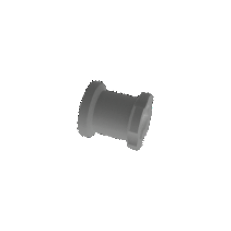

In [114]:
random_class = random.randrange(16)
random_sample = random.randrange(100)

prediction_sample = cv.imread( os.path.join( classes_dirs_with_data_aug[random_class], os.listdir(classes_dirs_with_data_aug[random_class])[random_sample] ) )
plt.rcParams["figure.figsize"] = (5,4)
plt.subplot(1, 1, 1)
plt.imshow(cv.cvtColor(prediction_sample,cv.COLOR_BGR2RGB))
plt.axis("off")

prediction_sample = np.expand_dims(prediction_sample, axis = 0)
print("prediction sample sahpe is:")
print(prediction_sample.shape)
model_prediction_vector = dummy_cnn.predict(prediction_sample)[0]


## 8 - CNN with tunned hyperparameters

In [9]:
def get_cnn_model_2():
  model = Sequential()
  model.add(Input(shape= (200,200,3)))
  model.add(Rescaling(1.0/255.0))
  model.add(Conv2D(32, (5,5), activation = "relu", kernel_initializer="he_normal"))
  model.add(Dropout(0.4))
  model.add( MaxPooling2D() )
  model.add(Conv2D(64, (10,10), activation = "relu", kernel_initializer="he_normal"))
  model.add(Dropout(0.4))
  model.add( MaxPooling2D() )  
  model.add(Conv2D(64, (15,15), activation = "relu", kernel_initializer="he_normal")) # size output here should be 50*50
  model.add(Dropout(0.4))  
  model.add(Flatten())  
  model.add(Dense(128,activation = "relu", kernel_initializer="he_normal"))
  model.add(Dropout(0.4))
  model.add(Dense(64,activation = "relu", kernel_initializer="he_normal"))
  model.add(Dropout(0.4))
  model.add(Dense(32,activation = "relu", kernel_initializer="he_normal"))  
  model.add(Dropout(0.4))
  model.add(Dense(16,activation = "softmax", kernel_initializer="he_normal")) # otput corresponds to 16 classes
  
  return model

In [10]:
model2 = get_cnn_model_2()
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 196, 196, 32)      2432      
                                                                 
 dropout (Dropout)           (None, 196, 196, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 89, 89, 64)        204864    
                                                                 
 dropout_1 (Dropout)         (None, 89, 89, 64)        0         
                                                        

In [11]:
model2.compile(optimizer=Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=[ 'accuracy', BinaryAccuracy(), AUC(), ]) 

In [12]:
print("for train data: ")
train_dataset = image_dataset_from_directory( os.path.join(data_dir_final, "train") , image_size=(200,200), batch_size=10, label_mode = "categorical" )
print("for validation data: ")
validation_dataset = image_dataset_from_directory( os.path.join(data_dir_final, "validation") , image_size=(200,200), batch_size=10, label_mode = "categorical" )
print("for test data: ")
test_dataset = image_dataset_from_directory( os.path.join(data_dir_final, "test") , image_size=(200,200), batch_size=10, label_mode = "categorical" )

for train data: 
Found 18323 files belonging to 16 classes.
for validation data: 
Found 2025 files belonging to 16 classes.
for test data: 
Found 5102 files belonging to 16 classes.


In [15]:
callbacks = [
    ModelCheckpoint(
        filepath= os.path.join( models_path, "cnn_model_2" ),
        save_best_only=True,
        monitor="val_loss"),
    EarlyStopping(monitor='loss', patience=5)
]

In [16]:
history = model2.fit(
    train_dataset,
    epochs=150,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/150
1831/1833 [============================>.] - ETA: 0s - loss: 2.7730 - accuracy: 0.0584 - binary_accuracy: 0.9375 - auc: 0.5010

1833/1833 [==============================] - 61s 33ms/step - loss: 2.7730 - accuracy: 0.0583 - binary_accuracy: 0.9375 - auc: 0.5009 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc: 0.5017
Epoch 2/150
1833/1833 [==============================] - 59s 32ms/step - loss: 2.7730 - accuracy: 0.0589 - binary_accuracy: 0.9375 - auc: 0.5008 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc: 0.5017
Epoch 3/150
1831/1833 [============================>.] - ETA: 0s - loss: 2.7731 - accuracy: 0.0570 - binary_accuracy: 0.9375 - auc: 0.5009

1833/1833 [==============================] - 61s 34ms/step - loss: 2.7731 - accuracy: 0.0569 - binary_accuracy: 0.9375 - auc: 0.5009 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc: 0.5017
Epoch 4/150
1833/1833 [==============================] - 60s 33ms/step - loss: 2.7730 - accuracy: 0.0592 - binary_accuracy: 0.9375 - auc: 0.5010 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc: 0.5017
Epoch 5/150
1833/1833 [==============================] - 60s 32ms/step - loss: 2.7730 - accuracy: 0.0586 - binary_accuracy: 0.9375 - auc: 0.5010 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc: 0.5017
Epoch 6/150
1831/1833 [============================>.] - ETA: 0s - loss: 2.7730 - accuracy: 0.0573 - binary_accuracy: 0.9375 - auc: 0.5009

1833/1833 [==============================] - 61s 33ms/step - loss: 2.7731 - accuracy: 0.0573 - binary_accuracy: 0.9375 - auc: 0.5009 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc: 0.5017
Epoch 7/150
1833/1833 [==============================] - 60s 33ms/step - loss: 2.7730 - accuracy: 0.0581 - binary_accuracy: 0.9375 - auc: 0.5009 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc: 0.5017
Epoch 8/150
1831/1833 [============================>.] - ETA: 0s - loss: 2.7730 - accuracy: 0.0585 - binary_accuracy: 0.9375 - auc: 0.5010

1833/1833 [==============================] - 61s 33ms/step - loss: 2.7730 - accuracy: 0.0585 - binary_accuracy: 0.9375 - auc: 0.5010 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc: 0.5017
Epoch 9/150
1833/1833 [==============================] - 60s 32ms/step - loss: 2.7730 - accuracy: 0.0585 - binary_accuracy: 0.9375 - auc: 0.5006 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc: 0.5017
Epoch 10/150
1833/1833 [==============================] - 59s 32ms/step - loss: 2.7731 - accuracy: 0.0587 - binary_accuracy: 0.9375 - auc: 0.5009 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc: 0.5017
Epoch 11/150
1833/1833 [==============================] - 60s 32ms/step - loss: 2.7730 - accuracy: 0.0577 - binary_accuracy: 0.9375 - auc: 0.5010 - val_loss: 2.7726 - val_accuracy: 0.0627 - val_binary_accuracy: 0.9375 - val_auc: 0.5017
Epoch 12/150
1833/1833 [==============================] - 59s 32ms/ste

## N - Excecuting block

In [ ]:
while True:
  temp = 1